In [1]:
import pandas as pd
import os
import torch
import numpy as np
import nltk
import string
from tqdm.notebook import tqdm
import wikipedia
import pickle
import matplotlib.pyplot as plt
from yaspin import yaspin

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bavik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bavik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
data_dir = "./data/"

In [16]:
stopwords = set(nltk.corpus.stopwords.words('english'))  

In [17]:
requests = pd.read_table(data_dir + "train.tsv", sep = '\t', header = 0).drop_duplicates('topic_id')
requests

,topic_id,initial_request,topic_desc,clarification_need,facet_id,facet_desc,question_id,question,answer
0,1,Tell me about Obama family tree.,Find information on President Barack Obama\'s ...,2,F0001,"Find the TIME magazine photo essay ""Barack Oba...",Q00384,are you interested in seeing barack obamas family,yes am interested in obamas family
39,102,What is Fickle Creek Farm,Find general information about Fickle Creek Fa...,2,F0014,Find general information about Fickle Creek Fa...,Q00059,are you going to purchase anything there,i dont know yet i just want general info about...
84,105,Tell me about sonoma county medical services.,What medical services are available in Sonoma ...,2,F0025,What medical services are available in Sonoma ...,Q00457,are you interested in the human services depar...,no i am looking for doctors or hospitals in so...
120,108,Tell me about of Ralph Owen Brester.,Find biographical information about Ralph Owen...,1,F0037,Find biographical information about Ralph Owen...,Q00297,are you interested in learning more about ralp...,yes and his biography
159,109,I'm looking for information about mayo clinic ...,What medical services are available at the May...,2,F0040,What medical services are available at the May...,Q00256,are you interested in jobs at mayo clinic jack...,no im interested in services provided at mayo ...
...,...,...,...,...,...,...,...,...,...
9113,234,tell me about dark chocolate health benefits,What are the health benefits associated with e...,1,F0539,What are the health benefits associated with e...,Q00430,are you interested in the different candles da...,no im more interested in the health benefits o...
9127,238,Tell me bio of george bush sr.,Find biographies of US President George H.W. B...,2,F0552,Find biographies of US President George H.W. B...,Q00402,are you interested in the 1992 presidential el...,yes i would like to know about george bush srs...
9139,240,Tell me more about us presidents,Find a list of the full names of US presidents.,3,F0558,Find a list of the full names of US presidents.,Q00201,are you interested in finding out the middle n...,no i am interested in the names of all us pres...
9151,261,Tell me about folk remedies for a sore throat.,What folk remedies are there for soothing a so...,1,F0633,What folk remedies are there for soothing a so...,Q00208,are you interested in folk remedies from a spe...,no just any folk remedies for a sore throat


In [8]:
df = pd.DataFrame(requests)
init_requests = df['initial_request'].to_numpy(dtype = str)
topic_ids = df['topic_id'].to_numpy(dtype = int)
clarification_need = df['clarification_need'].to_numpy(dtype = int)
req_data = [(topic_ids[i], init_requests[i], clarification_need[i]) for i in range(len(init_requests))]
req_data

[(1, 'Tell me about Obama family tree.', 2),
 (102, 'What is Fickle Creek Farm', 2),
 (105, 'Tell me about sonoma county medical services.', 2),
 (108, 'Tell me about of Ralph Owen Brester.', 1),
 (109, "I'm looking for information about mayo clinic Jacksonville FL", 2),
 (11, 'How to prepare for the GMAT?', 2),
 (111, "I'd like to learn about lymphoma in dogs", 2),
 (112, 'Is Kenmore heater good', 2),
 (113, 'Tell me more about HP mini 2140', 2),
 (115, 'Tell me about the pacific northwest laboratory.', 2),
 (116, 'What is California Franchise Tax Board', 2),
 (117, 'What are specific dangers of asbestos?', 2),
 (119, 'How to write a thank you letter after an interview?', 1),
 (12, 'how to hire disc jockey', 2),
 (120, 'TV on computer', 3),
 (122, 'Tell me more about Culpeper National Cemetry', 3),
 (124, 'Tell me about Bowflex Power Pro.', 2),
 (125, 'butter and margarine', 3),
 (127, "I'm looking for information on duchess county tourism", 3),
 (129, "Tell me information about Iowa'

In [8]:
req_data = np.array(req_data)
req_data

array([['1', 'Tell me about Obama family tree.', '2'],
       ['102', 'What is Fickle Creek Farm', '2'],
       ['105', 'Tell me about sonoma county medical services.', '2'],
       ['108', 'Tell me about of Ralph Owen Brester.', '1'],
       ['109',
        "I'm looking for information about mayo clinic Jacksonville FL",
        '2'],
       ['11', 'How to prepare for the GMAT?', '2'],
       ['111', "I'd like to learn about lymphoma in dogs", '2'],
       ['112', 'Is Kenmore heater good', '2'],
       ['113', 'Tell me more about HP mini 2140', '2'],
       ['115', 'Tell me about the pacific northwest laboratory.', '2'],
       ['116', 'What is California Franchise Tax Board', '2'],
       ['117', 'What are specific dangers of asbestos?', '2'],
       ['119', 'How to write a thank you letter after an interview?',
        '1'],
       ['12', 'how to hire disc jockey', '2'],
       ['120', 'TV on computer', '3'],
       ['122', 'Tell me more about Culpeper National Cemetry', '3'],
     

In [9]:
inputs = req_data[:,1]
labels = req_data[:,2]
topics = req_data[:,0]

In [10]:
inputs = np.array([req.lower() for req in inputs])
inputs = np.array([req.strip() for req in inputs])
inputs = np.array([req.translate(str.maketrans('', '', string.punctuation)) for req in inputs])
inputs = np.array([np.array(nltk.tokenize.word_tokenize(req)) for req in inputs])

In [11]:
inputs

array([array(['tell', 'me', 'about', 'obama', 'family', 'tree'], dtype='<U6'),
       array(['what', 'is', 'fickle', 'creek', 'farm'], dtype='<U6'),
       array(['tell', 'me', 'about', 'sonoma', 'county', 'medical', 'services'],
      dtype='<U8'),
       array(['tell', 'me', 'about', 'of', 'ralph', 'owen', 'brester'],
      dtype='<U7'),
       array(['im', 'looking', 'for', 'information', 'about', 'mayo', 'clinic',
       'jacksonville', 'fl'], dtype='<U12'),
       array(['how', 'to', 'prepare', 'for', 'the', 'gmat'], dtype='<U7'),
       array(['id', 'like', 'to', 'learn', 'about', 'lymphoma', 'in', 'dogs'],
      dtype='<U8'),
       array(['is', 'kenmore', 'heater', 'good'], dtype='<U7'),
       array(['tell', 'me', 'more', 'about', 'hp', 'mini', '2140'], dtype='<U5'),
       array(['tell', 'me', 'about', 'the', 'pacific', 'northwest', 'laboratory'],
      dtype='<U10'),
       array(['what', 'is', 'california', 'franchise', 'tax', 'board'],
      dtype='<U10'),
       array(['w

In [12]:
inputs = np.array([np.array([word for word in req if not word in stopwords]) for req in inputs])

In [13]:
inputs

array([array(['tell', 'obama', 'family', 'tree'], dtype='<U6'),
       array(['fickle', 'creek', 'farm'], dtype='<U6'),
       array(['tell', 'sonoma', 'county', 'medical', 'services'], dtype='<U8'),
       array(['tell', 'ralph', 'owen', 'brester'], dtype='<U7'),
       array(['im', 'looking', 'information', 'mayo', 'clinic', 'jacksonville',
       'fl'], dtype='<U12'),
       array(['prepare', 'gmat'], dtype='<U7'),
       array(['id', 'like', 'learn', 'lymphoma', 'dogs'], dtype='<U8'),
       array(['kenmore', 'heater', 'good'], dtype='<U7'),
       array(['tell', 'hp', 'mini', '2140'], dtype='<U4'),
       array(['tell', 'pacific', 'northwest', 'laboratory'], dtype='<U10'),
       array(['california', 'franchise', 'tax', 'board'], dtype='<U10'),
       array(['specific', 'dangers', 'asbestos'], dtype='<U8'),
       array(['write', 'thank', 'letter', 'interview'], dtype='<U9'),
       array(['hire', 'disc', 'jockey'], dtype='<U6'),
       array(['tv', 'computer'], dtype='<U8'),
    

In [14]:
inputs = np.array([' '.join(req) for req in inputs])

In [15]:
inputs

array(['tell obama family tree', 'fickle creek farm',
       'tell sonoma county medical services', 'tell ralph owen brester',
       'im looking information mayo clinic jacksonville fl',
       'prepare gmat', 'id like learn lymphoma dogs',
       'kenmore heater good', 'tell hp mini 2140',
       'tell pacific northwest laboratory',
       'california franchise tax board', 'specific dangers asbestos',
       'write thank letter interview', 'hire disc jockey', 'tv computer',
       'tell culpeper national cemetry', 'tell bowflex power pro',
       'butter margarine',
       'im looking information duchess county tourism',
       'tell information iowas food stamp program', 'map',
       'equal opportunity employer', 'im interested mothers day songs',
       'tell source nile', 'tell american military university',
       'tell rock gem shows',
       'im looking information jax chemical company',
       'im interested dinosaurs', 'information east ridge high school',
       'register d

In [16]:
len(inputs)

187

In [17]:
topics

array(['1', '102', '105', '108', '109', '11', '111', '112', '113', '115',
       '116', '117', '119', '12', '120', '122', '124', '125', '127',
       '129', '13', '131', '132', '135', '136', '137', '138', '14', '140',
       '141', '143', '144', '145', '146', '147', '148', '149', '15',
       '153', '154', '156', '158', '159', '16', '160', '162', '163',
       '167', '168', '173', '175', '176', '177', '179', '180', '183',
       '185', '186', '187', '188', '189', '19', '196', '197', '198',
       '199', '2', '21', '22', '23', '26', '28', '29', '3', '30', '31',
       '32', '33', '34', '36', '38', '39', '4', '40', '42', '43', '46',
       '48', '49', '5', '50', '52', '53', '54', '55', '56', '57', '58',
       '59', '6', '60', '61', '63', '65', '66', '67', '68', '69', '70',
       '72', '73', '75', '77', '80', '81', '82', '84', '88', '89', '9',
       '90', '93', '96', '97', '98', '99', '205', '211', '217', '221',
       '223', '224', '227', '228', '231', '232', '236', '239', '241',
    

In [47]:
with open('wikipedia_search_pages.pkl', 'wb') as filename:
    for i in tqdm(range(len(inputs))):
        results = wikipedia.search(inputs[i])[:100]
        summaries = []
        
        for sr in results:
            try:
                summaries.append(wikipedia.summary(sr))
            except Exception:
                results.remove(sr)
                continue

        add_dict = {topics[i]:{
            'initial_query': inputs[i],
            'search_results': results,
            'summaries': summaries
        }}
        pickle.dump(add_dict, filename)

D:\Installations\Python\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file D:\Installations\Python\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [2]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [57]:
summary_list = []
with open('wikipedia_search_pages.pkl', 'rb') as searchfile:
    for i in tqdm(range(len(inputs))):
        data = pickle.load(searchfile)
        topic_id = topics[i]
        record = list(data.values())[0]
        summaries = record['summaries']
        summary_list.extend(summaries)
        
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(summary_list)]

In [28]:
model_d2v = Doc2Vec(vector_size=300,alpha=0.025, min_count=1)
  
model_d2v.build_vocab(tagged_data)

for epoch in tqdm(range(300)):
    model_d2v.train(tagged_data,
                total_examples=model_d2v.corpus_count,
                epochs=model_d2v.epochs)

In [36]:
model_d2v.docvecs[1430]

array([-7.74840117e-02, -1.69429362e+00,  3.03123116e-01, -1.54193008e+00,
        1.59336388e+00,  7.08431125e-01, -1.83473110e-01,  5.08064687e-01,
       -5.93613505e-01,  1.02140820e+00, -2.18859315e+00, -1.01960099e+00,
       -8.19046021e-01,  7.95849383e-01, -1.86703205e+00,  1.43136054e-01,
       -1.02181554e+00,  1.18601453e+00, -7.51398504e-02, -9.87459302e-01,
       -6.13450527e-01, -3.05865884e+00, -4.85253751e-01, -7.03024685e-01,
        7.58755445e-01, -1.11999261e+00,  5.35492182e-01,  2.85996646e-01,
       -6.55032098e-01,  1.69881471e-02,  1.58164844e-01,  1.01562142e+00,
       -4.26797420e-01, -6.96641445e-01, -1.68499279e+00,  2.92518944e-01,
        1.51279068e+00, -8.53853703e-01, -3.08334976e-01, -1.53130293e+00,
        7.37686098e-01,  4.67842489e-01,  5.24221808e-02,  1.52527928e+00,
       -4.76374269e-01,  5.09923995e-01, -3.56414795e-01, -7.04207659e-01,
       -1.24596369e+00, -1.04954982e+00,  2.71840274e-01,  2.10909057e+00,
        2.68969033e-02, -

In [43]:
f = open('wikipedia_search_pages.pkl', 'rb')
j = 0
with open('wikipedia_search_pages_d2v.pkl', 'wb') as savefile:
    for i in tqdm(range(len(inputs))):
        data = pickle.load(f)
        topic_id = topics[i]
        record = list(data.values())[0]
        initial_query = record['initial_query']
        search_results = record['search_results']
        summaries = record['summaries']
        summary_encodings = []
        for summary in summaries:
            summary_encodings.append(model_d2v.docvecs[j])
            j += 1
        add_dict = {topic_id:{
            'initial_query': initial_query,
            'search_results': search_results,
            'summaries': summaries,
            'summary_encodings': summary_encodings
        }        
        }
        pickle.dump(add_dict, savefile)
f.close()

In [8]:
f = open('wikipedia_search_pages_d2v.pkl', 'rb')
pickle.load(f)

{'1': {'initial_query': 'tell obama family tree',
  'search_results': ['Family of Barack Obama',
   'Michelle Obama',
   'Barack Obama',
   'Max Kennedy',
   'Caroline Kennedy',
   'Timeline of the Barack Obama presidency (2009)',
   'Timeline of the Barack Obama presidency (2016–January 2017)',
   'Ted Kennedy'],
  'summaries': ['The family of Barack Obama, the 44th president of the United States, and his wife Michelle Obama is made up of people of Kenyan (Luo), African-American, and Old Stock American (including originally English, Scots-Irish, Welsh, German, and Swiss) ancestry. Their immediate family was the first family of the United States from 2009 to 2017. The Obamas are the first such family of African-American descent.',
   "Michelle LaVaughn Obama (née Robinson; born January 17, 1964) is an American attorney and author who was the first lady of the United States from 2009 to 2017. She is married to the 44th president of the United States, Barack Obama, and was the first Afri

In [53]:
from sentence_transformers import SentenceTransformer
import re

In [61]:
summary_list = [s.translate(str.maketrans('', '', string.punctuation)) for s in summary_list]

In [62]:
summary_list = [s.strip() for s in summary_list]

In [63]:
summary_list

['The family of Barack Obama the 44th president of the United States and his wife Michelle Obama is made up of people of Kenyan Luo AfricanAmerican and Old Stock American including originally English ScotsIrish Welsh German and Swiss ancestry Their immediate family was the first family of the United States from 2009 to 2017 The Obamas are the first such family of AfricanAmerican descent',
 'Michelle LaVaughn Obama née Robinson born January 17 1964 is an American attorney and author who was the first lady of the United States from 2009 to 2017 She is married to the 44th president of the United States Barack Obama and was the first AfricanAmerican first lady\nRaised on the South Side of Chicago Illinois Obama is a graduate of Princeton University and Harvard Law School In her early legal career she worked at the law firm Sidley Austin where she met Barack Obama She subsequently worked in nonprofits and as the associate dean of Student Services at the University of Chicago as well as the 

In [66]:
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [67]:
summary_list_encoded = []
for i in tqdm(range(len(summary_list))):
    summary_list_encoded.append(bert_model.encode(summary_list[i]))

In [72]:
summary_list_encoded[2].shape

(768,)

In [73]:
f = open('wikipedia_search_pages.pkl', 'rb')
with open('wikipedia_search_pages_sbert.pkl', 'wb') as savefile:
    for i in tqdm(range(len(inputs))):
        data = pickle.load(f)
        topic_id = topics[i]
        record = list(data.values())[0]
        initial_query = record['initial_query']
        search_results = record['search_results']
        summaries = record['summaries']
        summary_encodings = []
        for summary in summaries:
            summary_encodings.append(bert_model.encode(summary))
        add_dict = {topic_id:{
            'initial_query': initial_query,
            'search_results': search_results,
            'summaries': summaries,
            'summary_encodings': summary_encodings
        }        
        }
        pickle.dump(add_dict, savefile)
f.close()

In [1]:
f = open('wikipedia_search_pages_sbert.pkl', 'rb')

In [2]:
data = pickle.load(f)
data

NameError: name 'pickle' is not defined

In [12]:
data = list(data.values())[0]
data['summary_encodings']

[array([ 1.08983278e-01,  6.37869537e-02,  3.95668894e-01, -1.07206412e-01,
         9.09737468e-01, -9.85432565e-01, -6.58760592e-02, -2.35756993e-01,
        -5.48788980e-02, -2.24037677e-01,  1.14451528e-01,  4.00799245e-01,
         6.46943986e-01,  4.51111227e-01,  3.42562765e-01,  3.51288170e-01,
        -4.13247466e-01, -2.50947606e-02,  3.77614141e-01, -1.10730752e-01,
         5.87082431e-02,  2.64209598e-01,  5.50624847e-01, -2.19898328e-01,
         3.69402617e-01, -1.69955537e-01, -2.18765158e-02, -3.95082831e-01,
        -6.95714116e-01,  4.94112104e-01, -4.01804924e-01,  6.41768098e-01,
        -5.72511137e-01, -4.55551356e-01, -5.38215280e-01,  7.94403493e-01,
         3.57635498e-01,  9.34294313e-02,  2.49342993e-01,  1.00932971e-01,
        -4.14328396e-01, -6.73840284e-01,  1.47418931e-01,  3.46366763e-01,
        -1.55891192e+00, -4.01650935e-01,  6.07180417e-01,  1.06733724e-01,
         2.98078060e-01, -1.31974280e-01,  1.01438200e+00,  7.44002685e-02,
        -4.9

In [73]:
enc = np.array(data['summary_encodings'])

In [74]:
enc.shape

(6, 768)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
cosine_similarity(enc)

array([[0.9999997 , 0.7666361 , 0.7866731 , 0.67714906, 0.7598374 ,
        0.76828   ],
       [0.7666361 , 1.0000001 , 0.8662471 , 0.73533666, 0.69443196,
        0.6985211 ],
       [0.7866731 , 0.8662471 , 1.0000002 , 0.7288932 , 0.7597414 ,
        0.75553906],
       [0.67714906, 0.73533666, 0.7288932 , 1.        , 0.61000407,
        0.6198168 ],
       [0.7598374 , 0.69443196, 0.7597414 , 0.61000407, 0.99999964,
        0.9417044 ],
       [0.76828   , 0.6985211 , 0.75553906, 0.6198168 , 0.9417044 ,
        0.99999976]], dtype=float32)

In [21]:
from sklearn.decomposition import PCA

In [22]:
enc_pca_sbert = []
enc_pca_d2v = []

In [9]:
f = open('wikipedia_search_pages_sbert.pkl', 'rb')

In [13]:
data = pickle.load(f)
data

{'108': {'initial_query': 'tell ralph owen brester',
  'search_results': [],
  'summaries': [],
  'summary_encodings': []}}

In [74]:
record = list(data.values())[0]

In [75]:
enc = record['summary_encodings']

In [76]:
enc= np.array(enc)
enc.shape

(8, 768)

In [77]:
pca = PCA(n_components=2)
pca.fit(enc)

PCA(n_components=2)

In [78]:
enc_pca = pca.transform(enc)

In [79]:
enc_pca_sbert.append(enc_pca)
enc_pca

array([[-6.1093135 ,  8.478033  ],
       [ 6.6347313 , -2.373464  ],
       [-6.347932  , -2.3395107 ],
       [ 5.0356526 ,  3.9105606 ],
       [ 2.7081456 ,  0.62696743],
       [-2.5414808 , -4.6605864 ],
       [-2.2985413 , -5.76666   ],
       [ 2.9187372 ,  2.1246576 ]], dtype=float32)

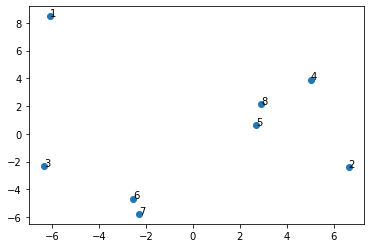

In [80]:
n = range(len(enc_pca))
_, ax = plt.subplots()
ax.scatter(enc_pca[:, 0], enc_pca[:, 1])
for i, txt in enumerate(n):
    ax.annotate(txt +1, (enc_pca[i, 0], enc_pca[i, 1]))

In [47]:
f1 = open('wikipedia_search_pages_d2v.pkl', 'rb')

In [84]:
data = pickle.load(f1)
data

{'115': {'initial_query': 'tell pacific northwest laboratory',
  'search_results': ['Sting jet',
   'BirdNote',
   'Oceania',
   'Pacific decadal oscillation',
   'Attack on Pearl Harbor',
   "Franklin's lost expedition",
   'Aequorea victoria',
   'United States Department of Energy',
   'Atomic bombings of Hiroshima and Nagasaki'],
  'summaries': ['A sting jet is a meteorological phenomenon which has been postulated to cause some of the most damaging winds in extratropical cyclones, developing according to the Shapiro-Keyser model (though perhaps not exclusively) of oceanic cyclones.',
   'BirdNote is a nonprofit radio program dedicated to the conservation of birds and their habitats.  BirdNote shows are two-minute vignettes that incorporate the sounds of birds with stories that illustrate their way of life. Shows can be heard on radio, online, and via podcast.\nThe BirdNote broadcast originated in the Pacific Northwest under the umbrella of the Seattle Audubon Society, a chapter of 

In [85]:
record = list(data.values())[0]
enc = record['summary_encodings']
enc = np.array(enc)
enc.shape

(8, 300)

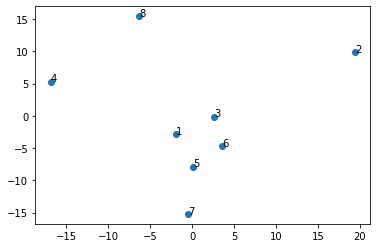

In [86]:
pca1 = PCA(n_components = 2)
enc_pca = pca1.fit_transform(enc)
enc_pca_d2v.append(enc_pca)
n = range(len(enc_pca))
_, ax = plt.subplots()
ax.scatter(enc_pca[:, 0], enc_pca[:, 1])
for i, txt in enumerate(n):
    ax.annotate(txt +1, (enc_pca[i, 0], enc_pca[i, 1]))

In [142]:
len(enc_pca_d2v)

4

In [143]:
enc_pca_sbert = np.array(enc_pca_sbert)
enc_pca_d2v = np.array(enc_pca_d2v)

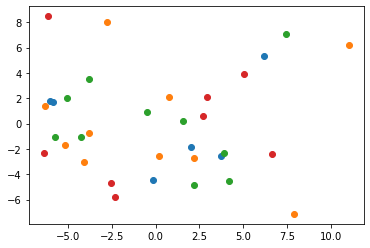

In [149]:
for i in range(4):
    plt.scatter(enc_pca_sbert[i][:, 0], enc_pca_sbert[i][:, 1])

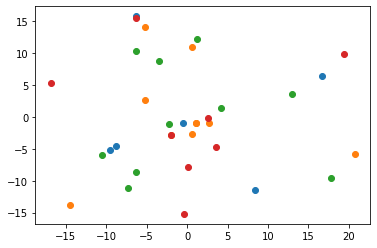

In [150]:
for i in range(4):
    plt.scatter(enc_pca_d2v[i][:, 0], enc_pca_d2v[i][:, 1])

In [3]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [16]:
f = open('retrieved_docs_encoded.pkl', 'rb')

docs = {}
with yaspin().arc:
    while True:
        try:
            data = pickle.load(f)
            tid = list(data.keys())[0]
            docs[tid] = list(data.values())[0]
        except EOFError:
            break

0m 

In [47]:
ks = list(docs.keys())

In [48]:
text_list = []
for i in tqdm(range(len(ks))):
    text_list.extend(docs[ks[i]]['docs'][:100])

In [49]:
len(text_list)

29800

In [50]:
tagged_data = []
for i, _d in enumerate(tqdm(text_list)):
    tagged_data.append(TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]))

In [51]:
model_d2v = Doc2Vec(vector_size=300,alpha=0.025, min_count=1)  
model_d2v.build_vocab(tagged_data)

In [52]:
with yaspin().arc:
    model_d2v.train(tagged_data,
                    total_examples=model_d2v.corpus_count,
                    epochs=50)

0m 

In [53]:
j = 0
with open('retrieved_docs_encoded_d2v.pkl', 'wb') as savefile:
    for i in tqdm(range(len(ks))):
        data = docs[ks[i]]
        topic_id = ks[i]
        texts = data['docs'][:100]
        enc = []
        for text in texts:
            enc.append(model_d2v.docvecs[j])
            j += 1
        add_dict = {topic_id:{
            'docs': texts,
            'encoded_docs': enc
        }        
        }
        pickle.dump(add_dict, savefile)

In [20]:
f = open('retrieved_docs_encoded_d2v.pkl', 'rb')

In [26]:
data = pickle.load(f)

In [27]:
data.keys()

dict_keys([221])

In [31]:
data[221]['encoded_docs'][0].shape

(300,)

In [33]:
proc_docs = {}
for i in tqdm(range(len(ks))):
    data = docs[ks[i]]
    proc_docs[ks[i]] = data['docs']

In [38]:
len(proc_docs[136])

1000

In [41]:
f = open('processed_docs.pkl', 'wb')
pickle.dump(proc_docs, f)

In [42]:
data = pickle.load(f)

UnsupportedOperation: read

In [43]:
f.close()

In [2]:
f = open('retrieved_docs_keywords.pkl', 'rb')

In [4]:
docs = {}
with yaspin().arc:
    while True:
        try:
            data = pickle.load(f)
            tid = list(data.keys())[0]
            docs[tid] = list(data.values())[0]
        except EOFError:
            break

0m 

In [6]:
ks = list(docs.keys())

text_list = []
for i in tqdm(range(len(ks))):
    text_list.extend(docs[ks[i]]['summary'])

In [8]:
len(text_list)

29800

In [9]:
tagged_data = []
for i, _d in enumerate(tqdm(text_list)):
    tagged_data.append(TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]))

In [10]:
model_d2v = Doc2Vec(vector_size=300,alpha=0.025, min_count=1)  
model_d2v.build_vocab(tagged_data)

In [11]:
with yaspin().arc:
    model_d2v.train(tagged_data,
                    total_examples=model_d2v.corpus_count,
                    epochs=30)

0m 

In [14]:
j = 0
with open('retrieved_docs_encoded_d2v_keywords.pkl', 'wb') as savefile:
    for i in tqdm(range(len(ks))):
        data = docs[ks[i]]
        topic_id = ks[i]
        texts = data['summary']
        enc = []
        for text in texts:
            enc.append(model_d2v.docvecs[j])
            j += 1
        add_dict = {topic_id:{
            'docs': texts,
            'encoded_docs': enc
        }        
        }
        pickle.dump(add_dict, savefile)

In [21]:
f = open('retrieved_docs_encoded_d2v.pkl', 'rb')

In [22]:
data = pickle.load(f)

In [23]:
data

{136: {'docs': [" A Letter written on Oct 30, 1937  A Letter written on Oct 30, 1937     Department of Chemistry, Yenching University, Peiping, - October  30, 1937.  Extracts from the Adolph Diary: 1937.   January: Ice skating on the Yenching lake at its prime. EHA, in  the 8th grade, North China American School, makes the hockey team. HMA,  freshman at Mount Holyoke College, amkes her second all-Holyoke athletic team  (basketball). WHA Jr., sophomore at Yale University (Calhoun College), works in  biology and plays football and basketball on his college team. DMA (8 yrs.)  tutors at home and specializes in dolls. - Through traffic opens on the trunk  line railway from Canton to Hankow; great strides in national reconstruction.   February: WHA serves on commission of five under the Council of  Public Health to prepare a code of nutrition standards for China. Cereals now  supply 85 percent of the food intake; we urge that this be replaced in part by  more green vegetables and legumes. M

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
enc = data[136]['encoded_docs']

In [26]:
len(enc)

100

In [28]:
cosine_similarity(enc)

array([[0.99999994, 0.17180729, 0.19625418, ..., 0.09520792, 0.23945108,
        0.16657114],
       [0.17180729, 1.0000001 , 0.4285403 , ..., 0.36810568, 0.3180814 ,
        0.22836162],
       [0.19625418, 0.4285403 , 1.0000001 , ..., 0.27956295, 0.3783759 ,
        0.16478932],
       ...,
       [0.09520792, 0.36810568, 0.27956295, ..., 0.9999999 , 0.23723547,
        0.16468766],
       [0.23945108, 0.3180814 , 0.3783759 , ..., 0.23723547, 1.0000004 ,
        0.2814876 ],
       [0.16657114, 0.22836162, 0.16478932, ..., 0.16468766, 0.2814876 ,
        1.0000006 ]], dtype=float32)